In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
sys.path.append(os.path.dirname(os.getcwd()))
from common import *

set_random_seed(RANDOM_STATE)

In [2]:
import tensorflow as tf

for gpu in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

2022-07-16 19:15:21.405060: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 19:15:21.407555: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 19:15:21.407771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


# 1. Load dataset

In [3]:
data              = pd.read_csv(join(PATH.input, "train_data.csv"))
sample_submission = pd.read_csv(join(PATH.input, "sample_submission.csv"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3859200 entries, 0 to 3859199
Data columns (total 13 columns):
 #   Column   Dtype  
---  ------   -----  
 0   TurbID   int64  
 1   Day      int64  
 2   Tmstamp  object 
 3   Wspd     float64
 4   Wdir     float64
 5   Etmp     float64
 6   Itmp     float64
 7   Ndir     float64
 8   Pab1     float64
 9   Pab2     float64
 10  Pab3     float64
 11  Prtv     float64
 12  Patv     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 382.8+ MB


# 2. Preprocessing

## 1) Feature engineering

In [4]:
%%time

MARKER      = -9999
IN_SEQ_LEN  = 2*144
OUT_SEQ_LEN = 2*144
STRIDE      = 144
SHUFFLE     = True
TEST_SIZE   = 0.1

# Imputing
data_imp = impute_data(data)

# Outlier handling
data_out = outlier_handler(data_imp, ['Etmp', 'Itmp', 'Wspd'])

# Feature engineering
data_fe = feature_engineering(data_out)

# Feature selection (select features)
cols = select_features(data_fe, threshold=0.2)  # cols[-1]: Patv

# Split dataset
train_x, train_y, val_x, val_y, test_x = make_train_val_test_data(data_fe, IN_SEQ_LEN, OUT_SEQ_LEN, STRIDE, SHUFFLE, TEST_SIZE)

# Feature selection (apply)
train_x = [d[cols] for d in train_x]
train_y = [d[cols] for d in train_y]
val_x   = [d[cols] for d in val_x]
val_y   = [d[cols] for d in val_y]
test_x  = [d[cols] for d in test_x]

# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(data_fe[cols].values)

train_x_norm = scale(train_x, scaler)
train_y_norm = scale(train_y, scaler)
val_x_norm   = scale(val_x, scaler)
val_y_norm   = scale(val_y, scaler)
test_x_norm  = scale(test_x, scaler)

# # Positional encoding
# P = positional_encoding(train_x_norm.shape[1], d=train_x_norm.shape[-1])[None, :]

# # Final data
# train_x_fin = train_x_norm + P
# train_y_fin = train_y_norm + P
# val_x_fin   = val_x_norm + P
# val_y_fin   = val_y_norm + P
# test_x_fin  = test_x_norm + P

# Final data
train_x_fin = train_x_norm
train_y_fin = train_y_norm
val_x_fin   = val_x_norm
val_y_fin   = val_y_norm
test_x_fin  = test_x_norm

# Set Patv of X to zero
train_x_fin[:, :, -1] = 0
val_x_fin[:, :, -1]   = 0
test_x_fin[:, :, -1]  = 0

idx_Pmax = list(cols).index('Pmax')

print("* Final data")
print("  - Train data(X, y):", np.shape(train_x_fin), np.shape(train_y_fin))
print("  - Validation data(X, y):", np.shape(val_x_fin), np.shape(val_y_fin))
print("  - Test data(X)    :", np.shape(test_x_fin))

* Data name: Imputing
  - Number of data: 3823222
  - Number of nan rows: 0
* Data name: Feature engineering
  - Number of data: 3823222
  - Number of nan rows: 0


100%|██████████| 134/134 [00:17<00:00,  7.71it/s]


* Data Split
  - Train data(X, y)     : (23427, 288, 43) (23427, 288, 43)
  - Validation data(X, y): (2678, 288, 43) (2678, 288, 43)
  - Test data(X)         : (134, 288, 43)
* Final data
  - Train data(X, y): (23427, 288, 20) (23427, 288, 20)
  - Validation data(X, y): (2678, 288, 20) (2678, 288, 20)
  - Test data(X)    : (134, 288, 20)
CPU times: user 2min 1s, sys: 11.9 s, total: 2min 13s
Wall time: 1min 53s


In [5]:
BATCH_SIZE = 32

train_ds = generate_dataset(train_x_fin, train_y_fin, batch_size=BATCH_SIZE)
val_ds   = generate_dataset(val_x_fin, val_y_fin, batch_size=BATCH_SIZE)
test_ds  = generate_dataset(test_x_fin, batch_size=1)

2022-07-16 19:17:18.473669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-16 19:17:18.474455: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 19:17:18.474639: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-16 19:17:18.474740: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

# 3. Modeling

In [6]:
from evaluation.metrics import CondLoss
from tensorflow import keras
from tensorflow.keras import layers, Sequential, Input

model = Sequential(name="GRU-Model") # Model
model.add(Input(shape=(train_x_fin.shape[1],train_x_fin.shape[2]), name='Input-Layer')) # Input Layer - need to speicfy the shape of inputs
model.add(layers.Bidirectional(layers.GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False), name='Hidden-GRU-Encoder-Layer')) # Encoder Layer
model.add(layers.RepeatVector(train_y_fin.shape[1], name='Repeat-Vector-Layer')) # Repeat Vector
model.add(layers.Bidirectional(layers.GRU(units=256, activation='tanh', recurrent_activation='sigmoid', stateful=False, return_sequences=True), name='Hidden-GRU-Decoder-Layer')) # Decoder Layer
model.add(layers.TimeDistributed(layers.Dense(units=train_y_fin.shape[2], activation='linear'), name='Output-Layer')) # Output Layer, Linear(x) = x

model.compile(optimizer='nadam',
              loss=CondLoss('rmse', 0),
              metrics=[keras.metrics.RootMeanSquaredError(), 'mae'])

# 4. Training

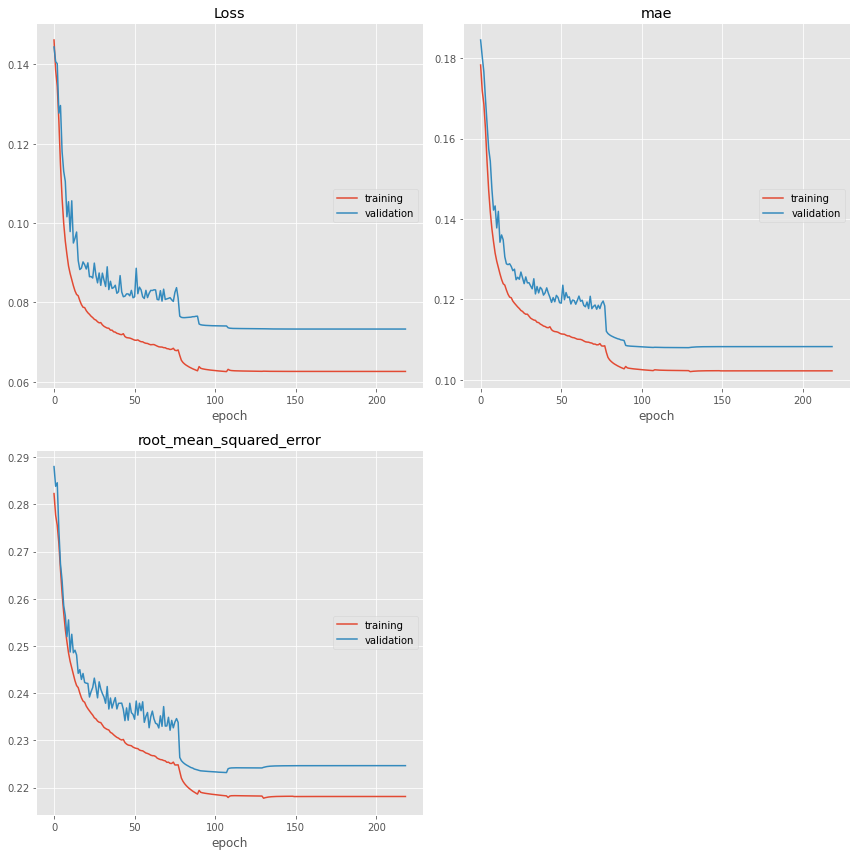

Loss
	training         	 (min:    0.063, max:    0.146, cur:    0.063)
	validation       	 (min:    0.073, max:    0.144, cur:    0.073)
mae
	training         	 (min:    0.102, max:    0.178, cur:    0.102)
	validation       	 (min:    0.108, max:    0.185, cur:    0.108)
root_mean_squared_error
	training         	 (min:    0.218, max:    0.282, cur:    0.218)
	validation       	 (min:    0.223, max:    0.288, cur:    0.225)
733/733 [==============================] - 35s 48ms/step - loss: 0.0626 - root_mean_squared_error: 0.2181 - mae: 0.1022 - val_loss: 0.0733 - val_root_mean_squared_error: 0.2246 - val_mae: 0.1083 - lr: 1.0000e-14


In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from livelossplot import PlotLossesKeras

history = model.fit(train_ds, validation_data=val_ds,
                    epochs=1000,
                    callbacks=[
                        PlotLossesKeras(),
                        EarlyStopping(patience=50),
                        ReduceLROnPlateau(patience=10)
                    ])

# 5. Check results

## 1) Training set

733/733 [==============================] - 13s 17ms/step


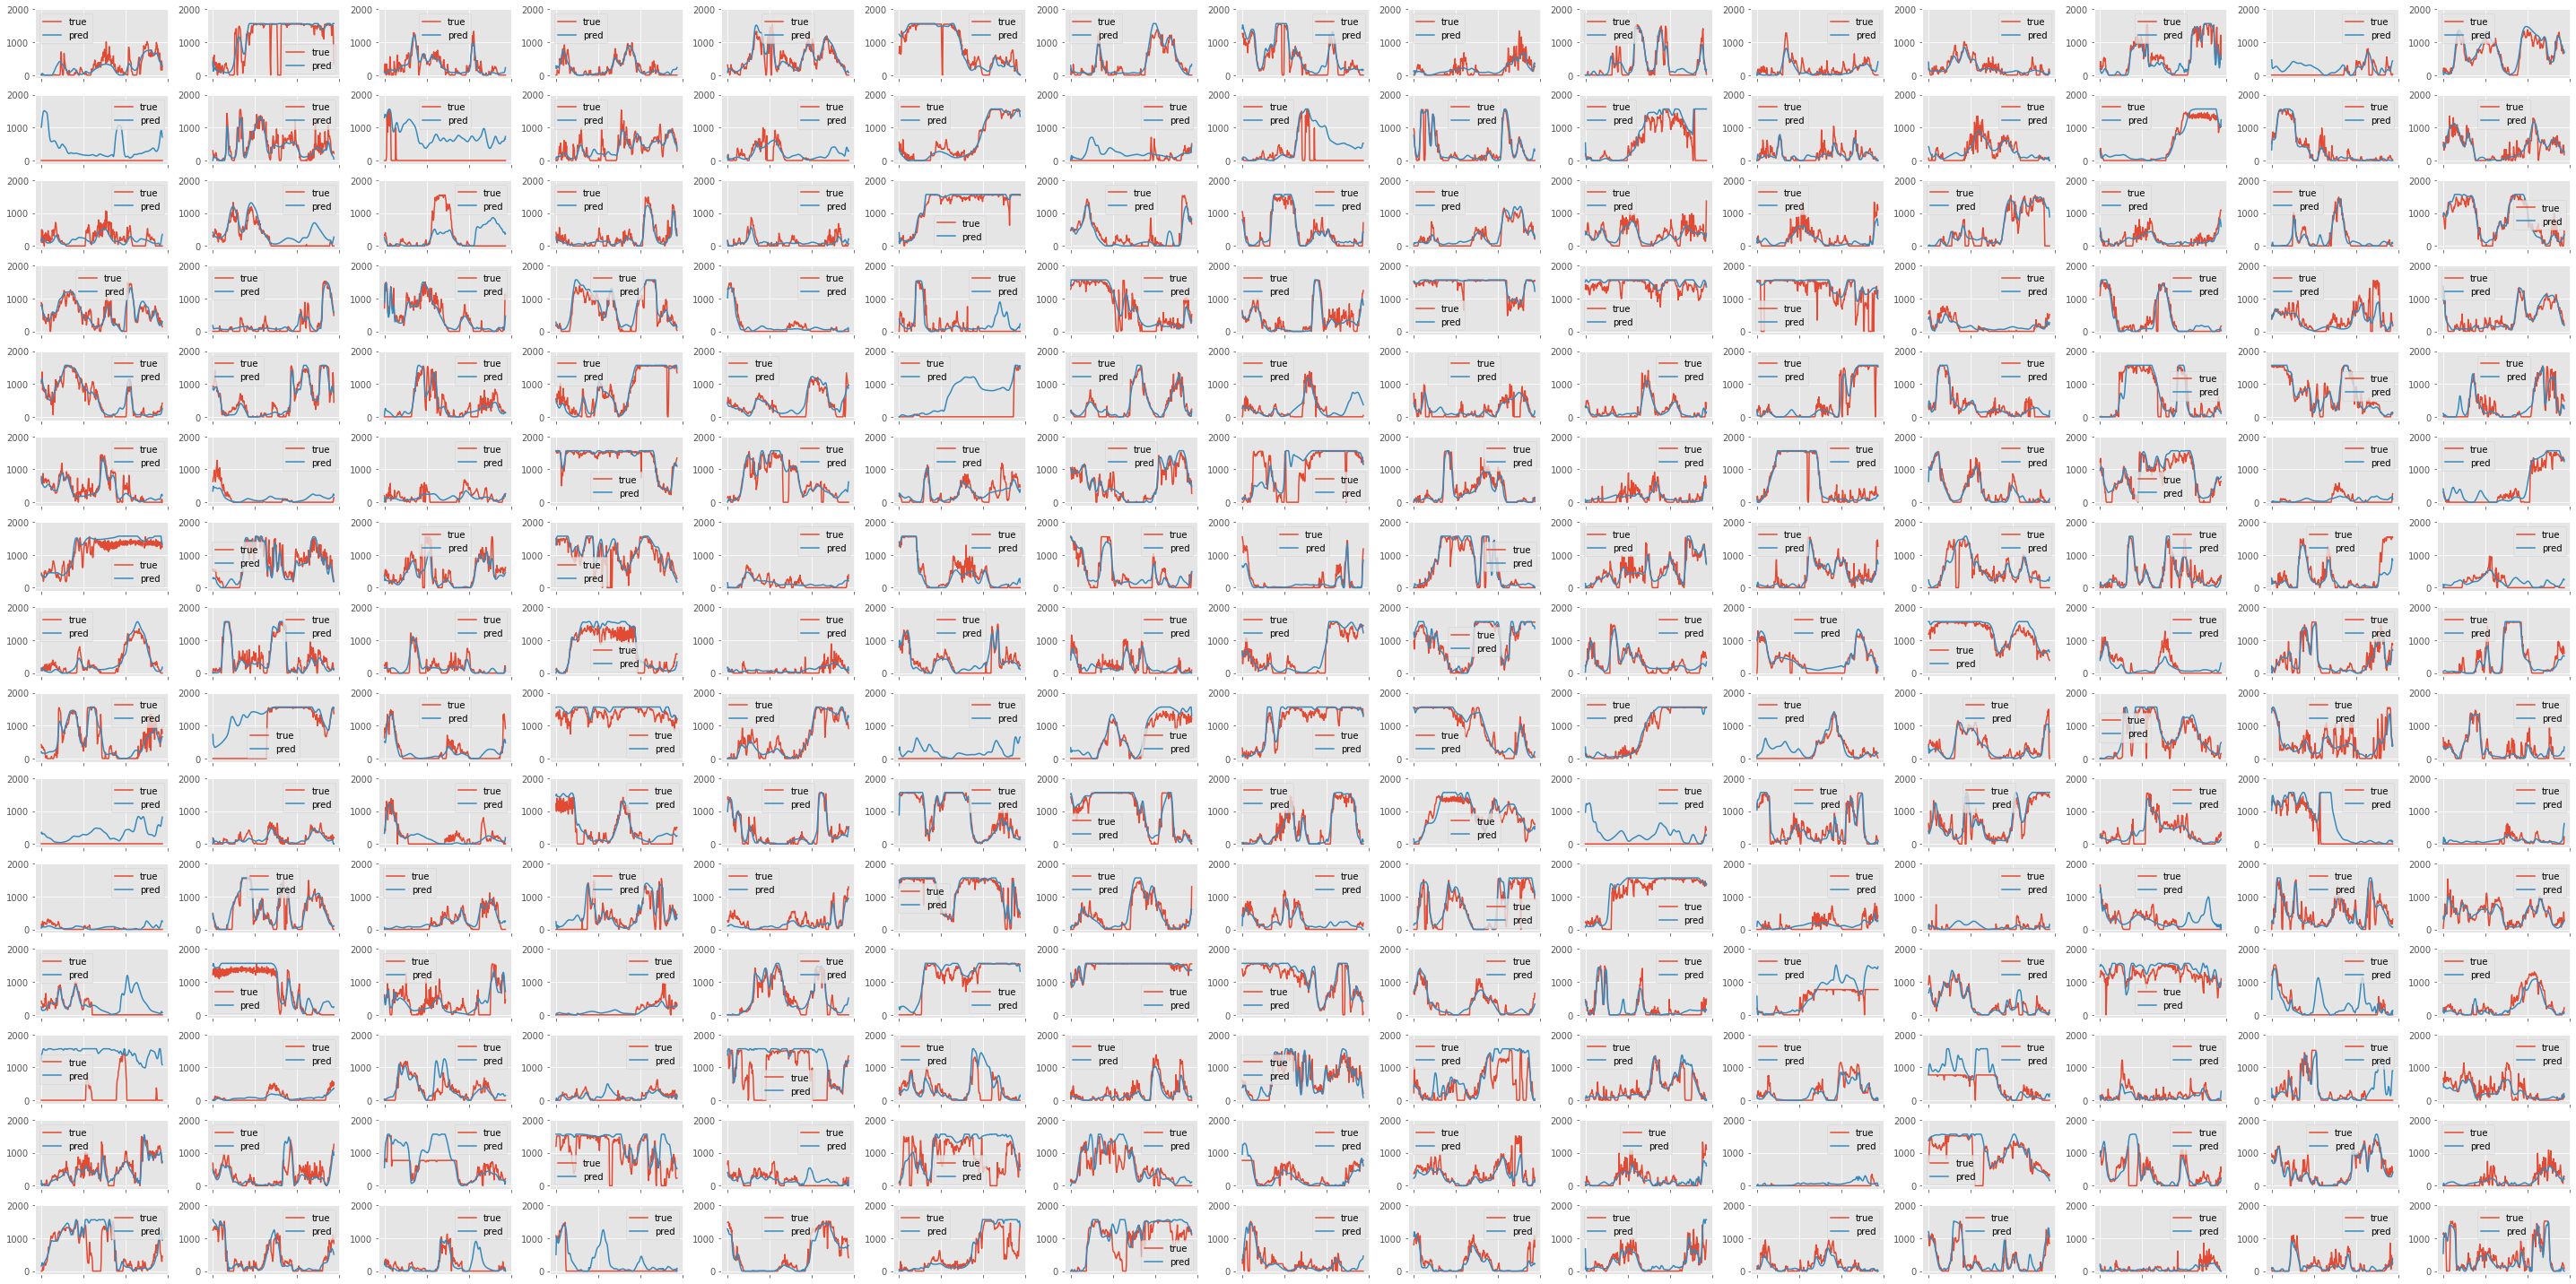

84/84 [==============================] - 2s 17ms/step


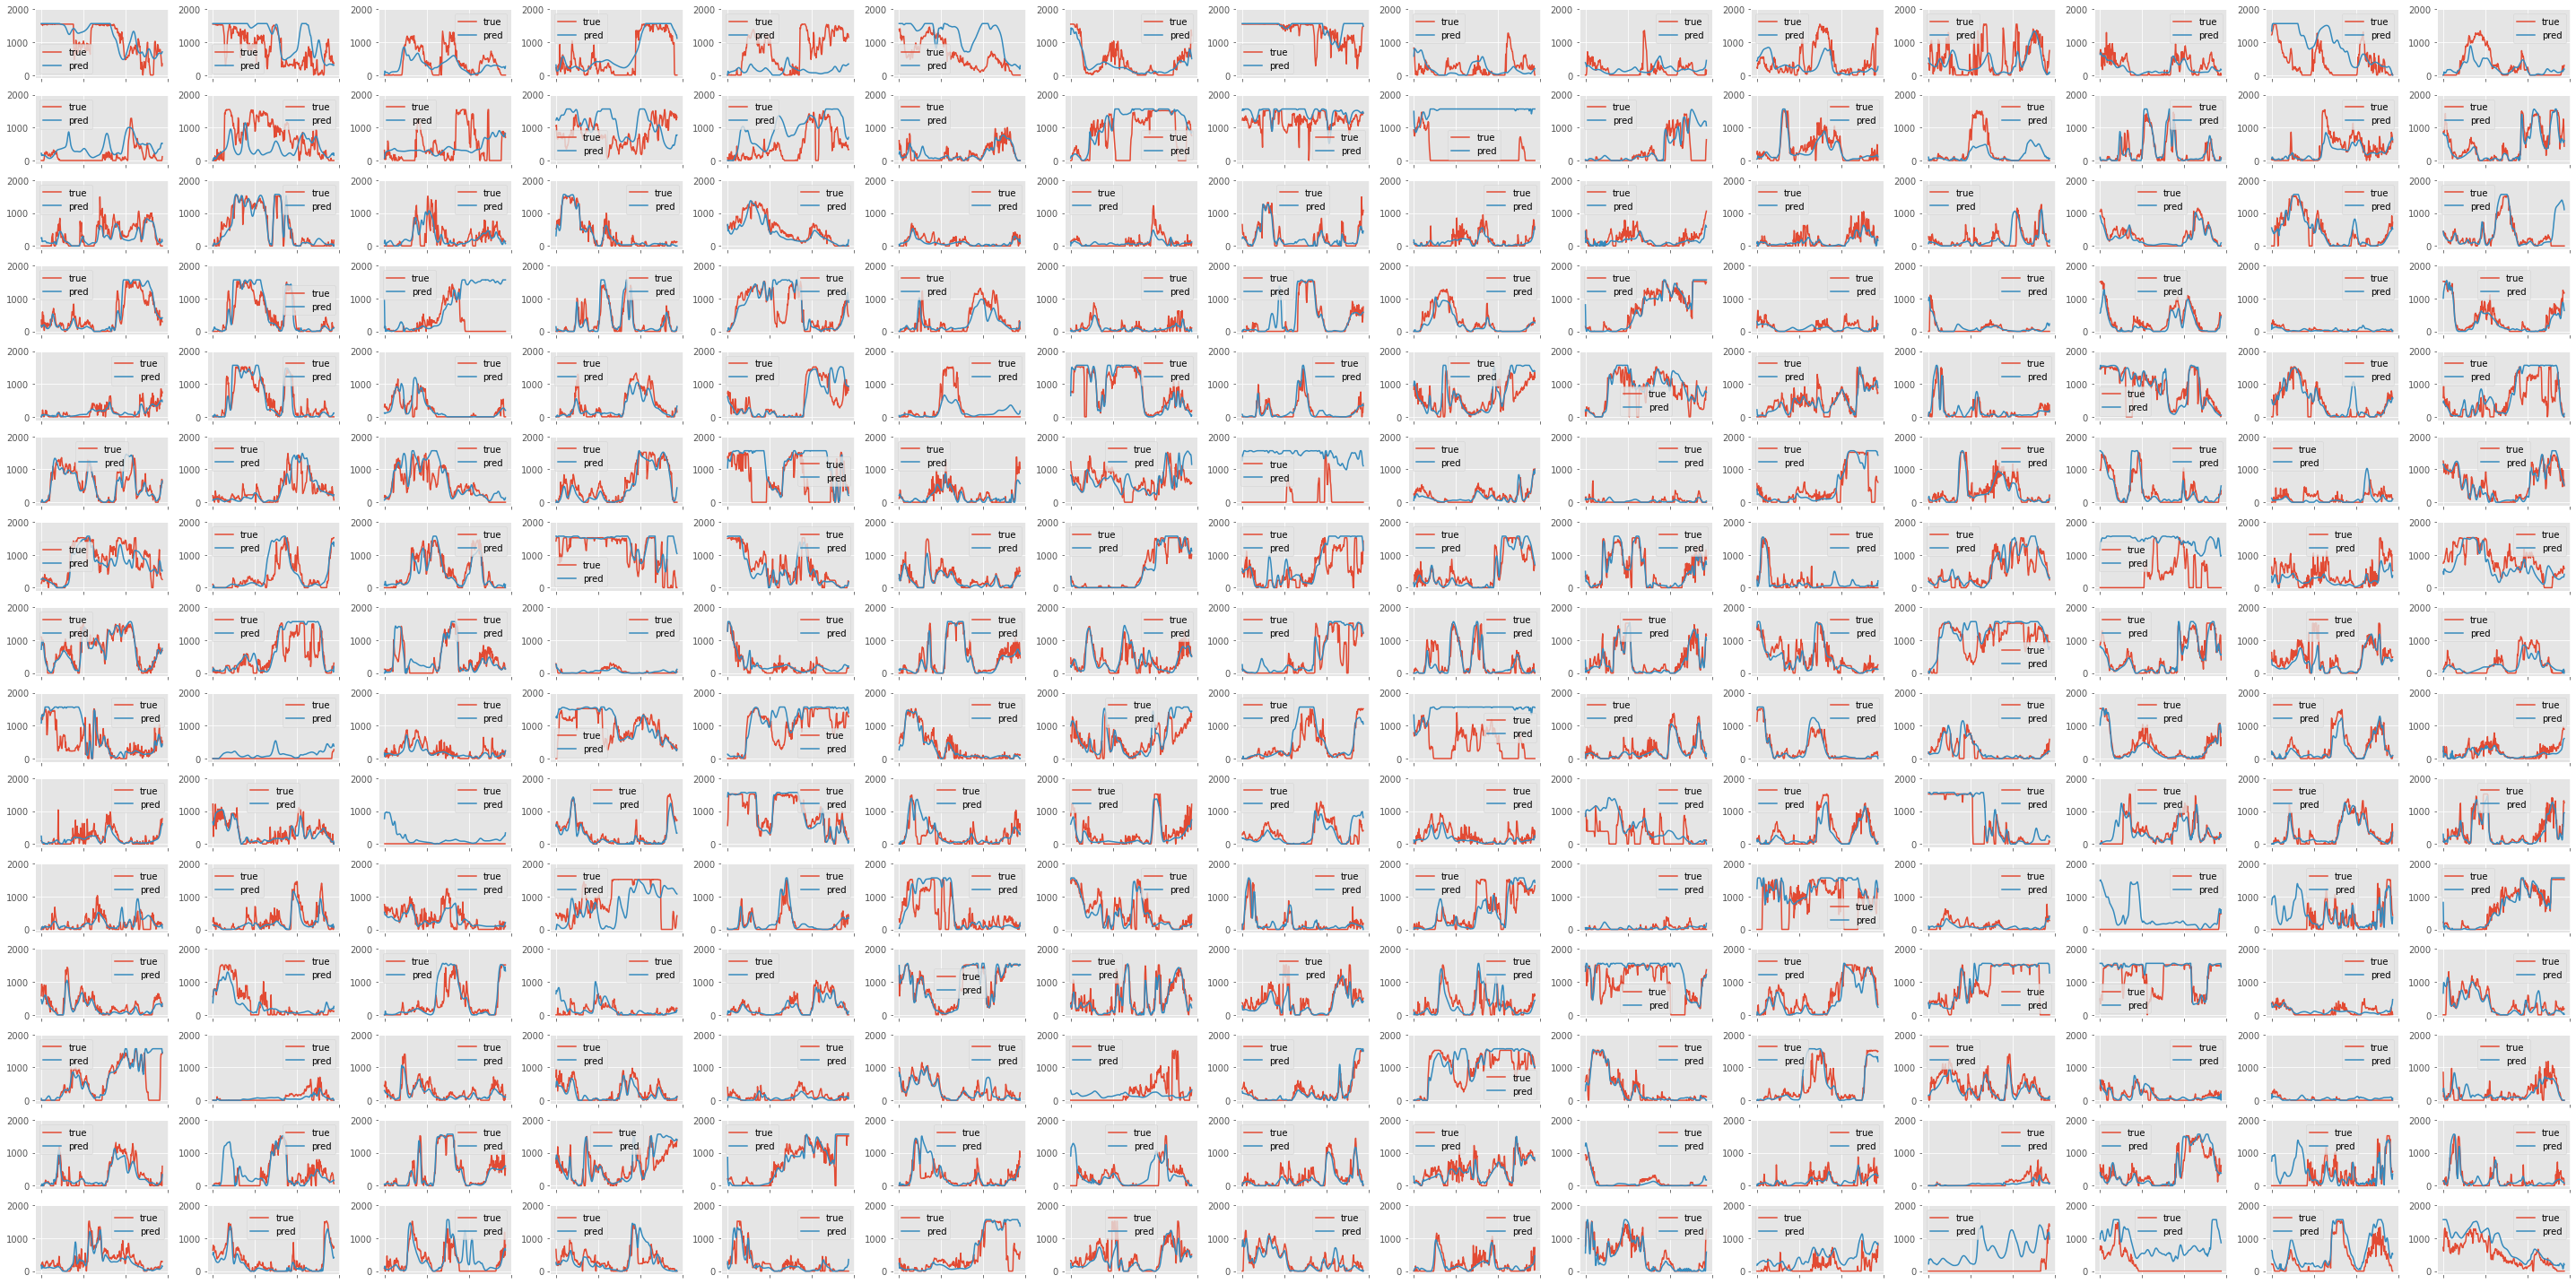

In [11]:
X      = train_x_fin
y_true = train_y_fin
y_pred = model.predict(X)
y_true_real = scaler.inverse_transform(y_true.reshape(-1, y_true.shape[-1])).reshape(y_true.shape)[:, :, -1]
y_pred_real = np.clip(scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)[:, :, 13], np.min(y_true_real), np.max(y_true_real))
visualize_result(y_true_real, y_pred_real, ylim=[-100, 2000])
plt.show()

X      = val_x_fin
y_true = val_y_fin
y_pred = model.predict(X)
y_true_real = scaler.inverse_transform(y_true.reshape(-1, y_true.shape[-1])).reshape(y_true.shape)[:, :, -1]
y_pred_real = np.clip(scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)[:, :, 13], np.min(y_true_real), np.max(y_true_real))
visualize_result(y_true_real, y_pred_real, ylim=[-100, 2000])

# 6. Generate submission

In [15]:
min_val = data_fe['Patv'].min()
max_val = data_fe['Patv'].max()

In [20]:
X      = test_x_fin
y_pred = model.predict(X)

y_pred_real = np.clip(scaler.inverse_transform(y_pred.reshape(-1, y_pred.shape[-1])).reshape(y_pred.shape)[:, :, 13], min_val, max_val)

sample_submission['Patv'] = y_pred_real.reshape(-1)
sample_submission.to_csv(join(PATH.output, "proposed19-use_all_features.csv"), index=False)

5/5 [==============================] - 0s 18ms/step
